# **Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# **Importing Skin Cancer Data**

**Reading the data**

**Importing all the important libraries**

In [126]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import requests
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [91]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [92]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Test")

In [93]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing** <br>
Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset** <br>
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:

## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data** <br>
Code to visualize one instance of all the nine classes present in the dataset

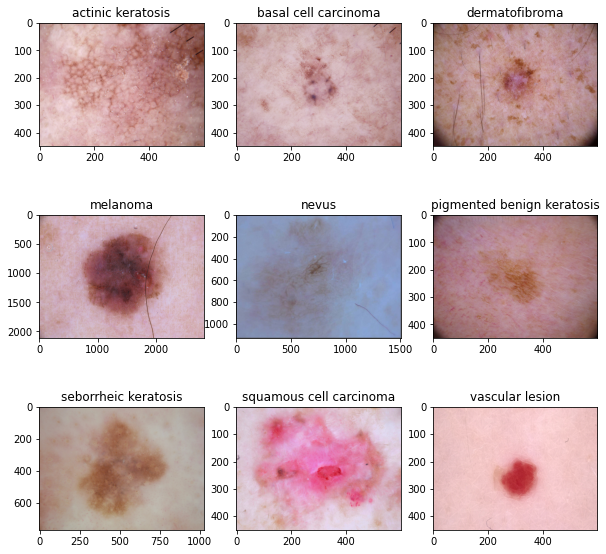

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model** <br>
CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

**Compile the model**<br>
Choose an appropirate optimiser and loss function for model training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

**Train the model**

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 250s 900ms/step - loss: 2.0591 - accuracy: 0.1875 - val_loss: 2.0194 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0399 - accuracy: 0.2031 - val_loss: 2.0297 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.9153 - accuracy: 0.2835 - val_loss: 1.8121 - val_accuracy: 0.3110
Epoch 4/20
56/56 [==============================] - 4s 80ms/step - loss: 1.7912 - accuracy: 0.3119 - val_loss: 1.6743 - val_accuracy: 0.3893
Epoch 5/20
56/56 [==============================] - 5s 81ms/step - loss: 1.7606 - accuracy: 0.3532 - val_loss: 1.7465 - val_accuracy: 0.3221
Epoch 6/20
56/56 [==============================] - 5s 81ms/step - loss: 1.6724 - accuracy: 0.3845 - val_loss: 1.6088 - val_accuracy: 0.4004
Epoch 7/20
56/56 [==============================] - 5s 81ms/step - loss: 1.6194 - accuracy: 0.4046 - val_loss: 1.5772 - val_accuracy: 0.4273
Epoch 8/20
56/56 [===

**Visualizing training results**

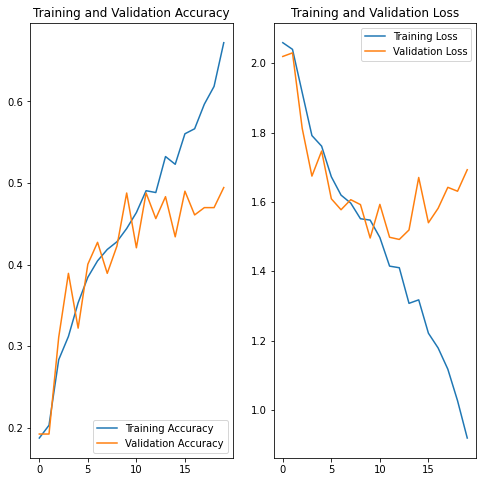

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings after the model fit, see if there is an evidence of model overfit or underfit**

**Finding on the first base model** <br>

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch <br>

The accuracy is just around 75-80% because there are enough features to remember the pattern. <br>

But again, it's too early to comment on the overfitting & underfitting debate <br>

**Create the model, compile and train the model to handel Overfit and Underfit**

In [16]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

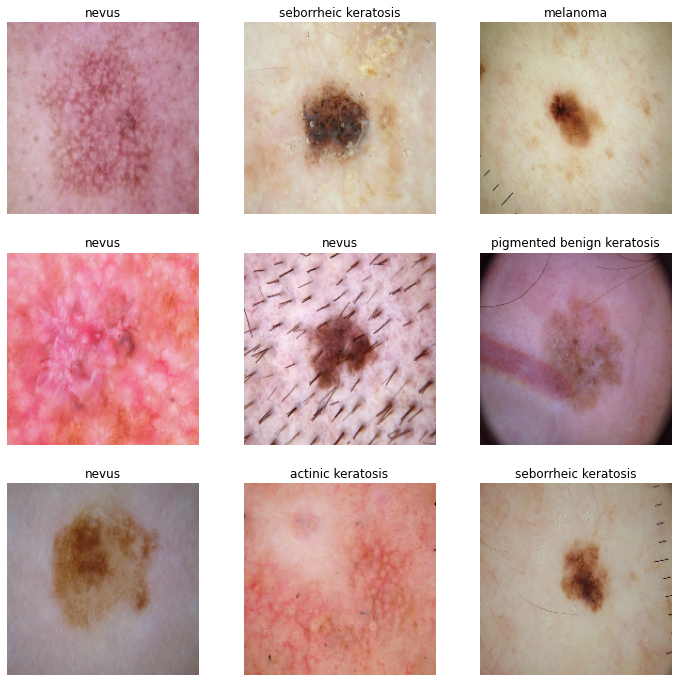

In [18]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [19]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 95ms/step - loss: 2.0745 - accuracy: 0.2098 - val_loss: 2.0294 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 5s 92ms/step - loss: 1.9946 - accuracy: 0.2282 - val_loss: 2.0225 - val_accuracy: 0.2819
Epoch 3/30
56/56 [==============================] - 5s 92ms/step - loss: 1.8890 - accuracy: 0.2946 - val_loss: 1.8321 - val_accuracy: 0.3065
Epoch 4/30
56/56 [==============================] - 5s 89ms/step - loss: 1.7661 - accuracy: 0.3527 - val_loss: 1.8887 - val_accuracy: 0.2886
Epoch 5/30
56/56 [==============================] - 5s 91ms/step - loss: 1.7034 - accuracy: 0.3711 - val_loss: 1.6376 - val_accuracy: 0.4139
Epoch 6/30
56/56 [==============================] - 5s 90ms/step - loss: 1.7034 - accuracy: 0.3884 - val_loss: 1.5990 - val_accuracy: 0.4474
Epoch 7/30
56/56 [==============================] - 5s 90ms/step - loss: 1.5709 - accuracy: 0.4392 - val_loss: 1.7181 - val_accuracy: 0.4430
Epoch 8/30
56/56 [======

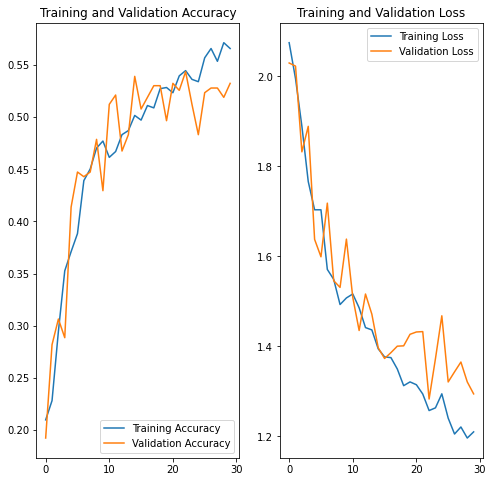

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

**Finding from Second Model** <br>
There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation <br>

We can increase the epochs to increase the accuracy so it's too early for judgement

**Find the distribution of classes in the training dataset.**
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
1,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
2,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
3,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
4,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2235,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2236,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2237,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion


In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
1,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
2,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
3,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
4,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2235,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2236,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2237,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion


<BarContainer object of 9 artists>

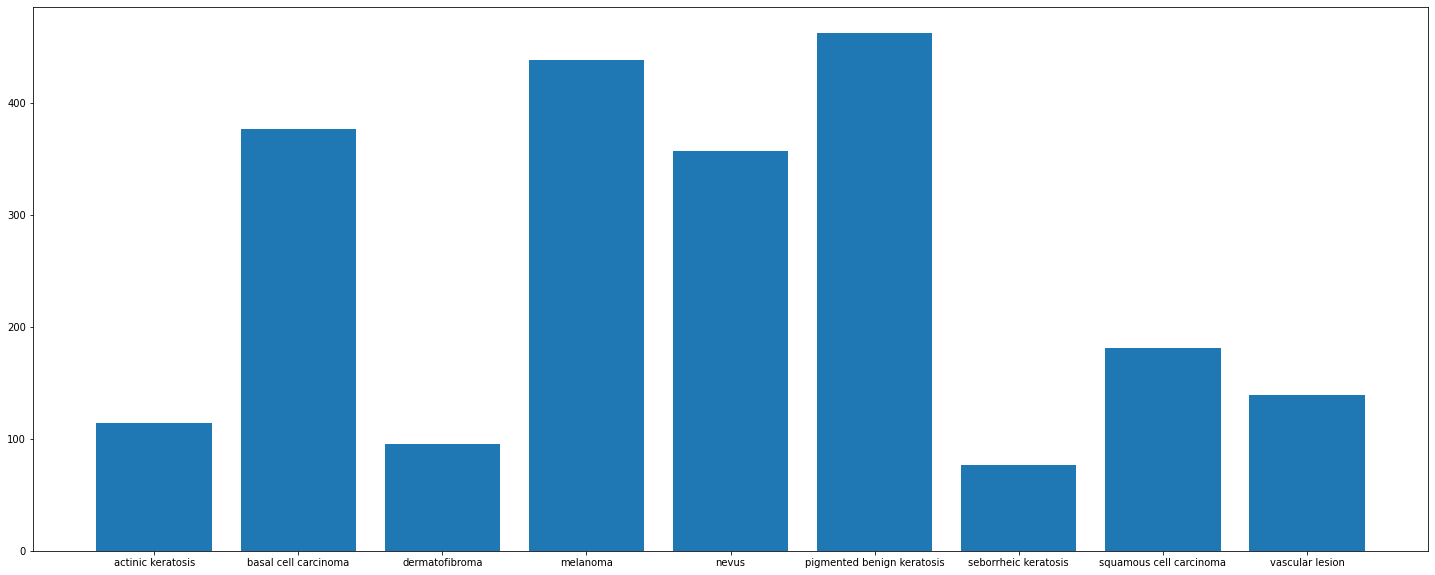

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**Write your findings here:**
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

**Answer-1 :**- seborrheic keratosis and dermatofibroma has least number of samples

**Answer-2:**- pigmented benign keratosis and melanoma have proprtionate number of classes

In [26]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

**Rectify the class imbalance** <br>
**Context:** You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [95]:
path_to_training_dataset = "/content/gdrive/MyDrive/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4C4FEF6D90>: 100%|██████████| 500/500 [00:19<00:00, 25.22 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4C52697050>: 100%|██████████| 500/500 [00:21<00:00, 23.69 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4C4FF71F50>: 100%|██████████| 500/500 [00:21<00:00, 23.03 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3872x2592 at 0x7F4C5260F610>: 100%|██████████| 500/500 [01:42<00:00,  4.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4C523F7E50>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4C520B2250>: 100%|██████████| 500/500 [00:24<00:00, 20.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4CE5D51250>: 100%|██████████| 500/500 [00:46<00:00, 10.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4C528B6910>: 100%|██████████| 500/500 [00:22<00:00, 22.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4C4FE78F90>: 100%|██████████| 500/500 [00:23<00:00, 21.25 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [96]:
#data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train/output")
#image_count_train1 = len(list(data_dir_train.glob('*/*.jpg')))
#print(image_count_train1)

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [97]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0032745.jpg_96012d6f-b258-46c2-ac02-36bb3118ae28.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0027269.jpg_72dc8a1c-35f5-43e7-a225-00802c8a9ee6.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_0ae015de-ec91-43c2-8b26-7e69f211ae97.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0032932.jpg_e7c6c90c-8e76-45e0-af0a-50cbbbbf7ef4.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_99fb9492-2b67-4dfb-bf8d-0c2a5f24e2d3.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0033158.jpg_ca274f4e-d2b6-4a0d-8c99-a75849530349.jpg',
 '/content/gdrive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0026349.jpg_48f9f413-aab0-45ac-8a29-ca380a64355b.jpg',
 '/content/gdrive/My

In [98]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [100]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [101]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [102]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Train the model on the data created using Augmentor**

In [103]:
batch_size = 32
img_height = 180
img_width = 180

In [104]:
data_dir_train="/content/gdrive/MyDrive/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 10 classes.
Using 8992 files for training.


In [105]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 10 classes.
Using 2247 files for validation.


**Create a training dataset**

** Create a validation dataset**

**Create your model (make sure to include normalization)**

In [127]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_29 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 90, 90, 64)        51264     
                                                      

**Compile your model (Choose optimizer and loss function appropriately)**

In [128]:
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

**Train your model**

In [129]:
epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 59s 202ms/step - loss: nan - accuracy: 0.0563 - val_loss: nan - val_accuracy: 0.0534 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - 56s 195ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - 57s 198ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0549
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
281/281 [==============================] - 58s 203ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534 - lr: 0.0010
Epoch 5/50
281/281 [==============================] - 56s 194ms/step - loss: nan - accuracy: 0.0549 - val_loss: nan - val_accuracy: 0.0534 - lr: 5.0000e-04
Epoch 6/50
281/281 [==============================] - 57s 197ms/step - loss: nan - accura

**Visualize the model results**

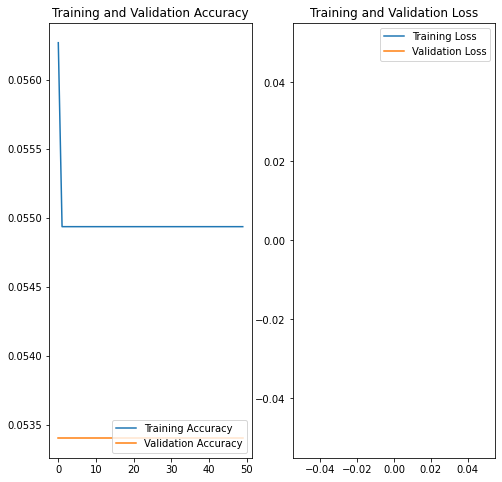

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**



*   Accuracy on training data has decreased  by using Augmentor library
*   The Model can be further improved by tuning the hyperparameter



